[SCCTS]:https://archive.ics.uci.edu/ml/datasets/Synthetic+Control+Chart+Time+Series

# Clustering Synthetic Time Series

This notebook aims to cluster a dataset of synthetic times series. The dataset, named [Synthetic Control Chart Time Series][SCCTS], was found on the UCI website and consists of 600 time-series of 60 points drawn from 6 different distributions.

Multiple distances are used: euclidean, Sakoe-Chiba DTW, Soft-DTW, DDTW. 

Even though soft-DTW yields the best results, they are not perfect by any means. Some feature-engineering is needed to improve results (on the way!).

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform, pdist
from tslearn.metrics import soft_dtw, dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from DTWpy.dtwpy import ddtw  # from github.com/gulzi/DTWpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from tqdm import tqdm
import multiprocessing as mp
%matplotlib inline
sns.set()

# Data

In [2]:
data = np.load('data/synthetic_control')

The data consist in 6\*100 time-series of length 60. Each group of a 100 is drawn from a different distribution.  
We plot below examples from each of the groups. 

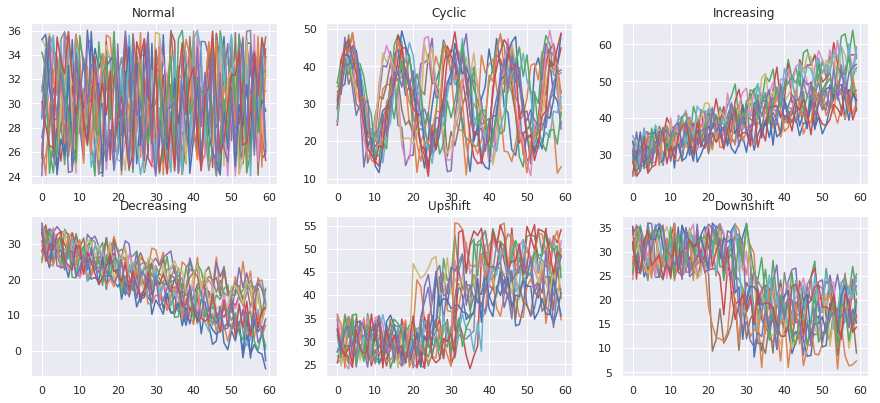

In [3]:
f, axarr = plt.subplots(2, 3, figsize=(15,6.5))
axarr[0, 0].plot(data[0:15].T)
axarr[0, 0].set_title('Normal')
axarr[0, 1].plot(data[100:115].T)
axarr[0, 1].set_title('Cyclic')
axarr[0, 2].plot(data[200:215].T)
axarr[0, 2].set_title('Increasing')
axarr[1, 0].plot(data[300:315].T)
axarr[1, 0].set_title('Decreasing')
axarr[1, 1].plot(data[400:415].T)
axarr[1, 1].set_title('Upshift')
axarr[1, 2].plot(data[500:515].T)
axarr[1, 2].set_title('Downshift');

We remove noise by applying a rolling average to all series. We also minmax scale the series.

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

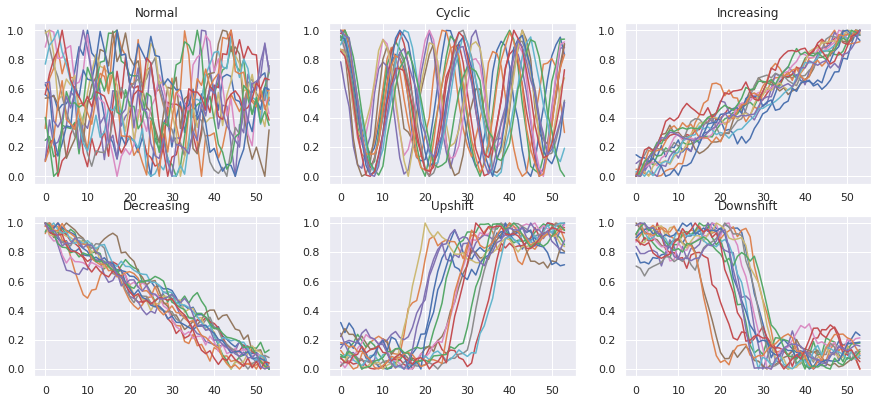

In [5]:
data = np.array([moving_average(a, n=7) for a in data])
data = TimeSeriesScalerMinMax().fit_transform(data).reshape(data.shape)

f, axarr = plt.subplots(2, 3, figsize=(15,6.5))
axarr[0, 0].plot(data[0:15].T)
axarr[0, 0].set_title('Normal')
axarr[0, 1].plot(data[100:115].T)
axarr[0, 1].set_title('Cyclic')
axarr[0, 2].plot(data[200:215].T)
axarr[0, 2].set_title('Increasing')
axarr[1, 0].plot(data[300:315].T)
axarr[1, 0].set_title('Decreasing')
axarr[1, 1].plot(data[400:415].T)
axarr[1, 1].set_title('Upshift')
axarr[1, 2].plot(data[500:515].T)
axarr[1, 2].set_title('Downshift');

# Distance matrices

We use the python multiprocessing package to calculate the distance matrices. This brings computation time down to reasonable levels.

The parser functions below are utils for the distance_matrix method. Each of them calculates the pairwise distances between one time-series and the rest of them. 

In [6]:
def ddtw_parser(ts_i):
    """
    :param ts_i: index (in data) of the current time-series
    :return: distance of the time-series to the remaining time-series
    """
    out = np.zeros(shape=data.shape[0])
    for ts_j in range(ts_i, data.shape[0]): 
        out[ts_j] = ddtw(data[ts_i], data[ts_j],
                         windowtype=None, windowsize=None, dist_only=True, normalized=True)
    return out

def sakoe_parser(ts_i):
    """
    :param ts_i: index (in data) of the current time-series
    :return: distance of the time-series to the remaining time-series
    """
    out = np.zeros(shape=data.shape[0])
    for ts_j in range(ts_i, data.shape[0]):
        out[ts_j] = dtw(data[ts_i], data[ts_j], 
                        global_constraint='sakoe_chiba', sakoe_chiba_radius=5)
    return out

def soft_dtw_parser(ts_i):
    """
    :param ts_i: index (in data) of the current time-series
    :return: distance of the time-series to the remaining time-series
    """
    out = np.zeros(shape=data.shape[0])
    for ts_j in range(ts_i, data.shape[0]):  # soft_dtw(x,x) != 0
        out[ts_j] = soft_dtw(data[ts_i], data[ts_j])
    return out

In [7]:
def distance_matrix(data, distance_parser):
    """
    :param data: pd.DataFrame with samples in rows 
    :param distance_parser: what distance function to use
    :return: pairwise distance matrix
    """

    with mp.Pool(processes=8) as pool:
        dist_mat = list(tqdm(pool.imap(distance_parser,range(data.shape[0])), total=data.shape[0]))

    dist_mat = np.array(dist_mat)    
    return dist_mat + dist_mat.T - np.diag(dist_mat.diagonal())  # make it symmetric 

In [8]:
euclidean_dist_mat = pairwise_distances(data, metric='euclidean')
euclidean_dist_mat = MinMaxScaler().fit_transform(euclidean_dist_mat).T

In [9]:
soft_dtw_dist_mat = distance_matrix(data, soft_dtw_parser)
soft_dtw_dist_mat = MinMaxScaler().fit_transform(soft_dtw_dist_mat).T

100%|██████████| 600/600 [00:14<00:00, 42.58it/s] 


In [10]:
sakoe_dist_mat = distance_matrix(data, sakoe_parser)
sakoe_dist_mat = MinMaxScaler().fit_transform(sakoe_dist_mat).T

100%|██████████| 600/600 [01:58<00:00,  5.08it/s]


In [11]:
ddtw_dist_mat = distance_matrix(data, ddtw_parser)
ddtw_dist_mat = MinMaxScaler().fit_transform(ddtw_dist_mat).T

100%|██████████| 600/600 [04:12<00:00,  2.37it/s]


# Clustering

## Heatmaps

We now plot the heatmap for each of the distance matrices.

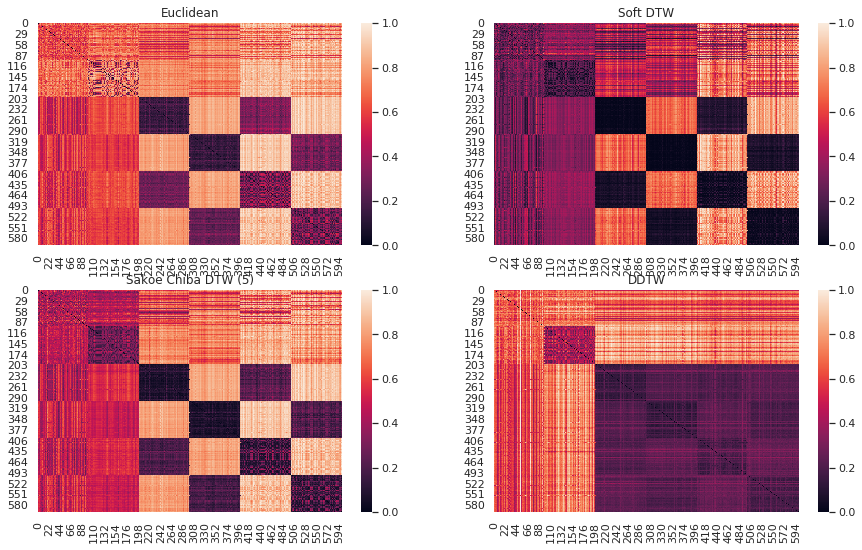

In [12]:
f, axarr = plt.subplots(2, 2, figsize=(15,9))
sns.heatmap(euclidean_dist_mat, ax=axarr[0, 0])
axarr[0, 0].set_title('Euclidean')
sns.heatmap(soft_dtw_dist_mat, ax=axarr[0, 1])
axarr[0, 1].set_title('Soft DTW')
sns.heatmap(sakoe_dist_mat, ax=axarr[1, 0])
axarr[1, 0].set_title('Sakoe Chiba DTW (5)');
sns.heatmap(ddtw_dist_mat, ax=axarr[1, 1])
axarr[1, 1].set_title('DDTW');

As we can see above and as mentionned on the UCI website, the couples *normal*/*cyclic*, *upshift*/*increasing* and *downshift*/*decreasing* seem to be hardest to tell apart, given the distances we work with.

This is especially true for the euclidean distance. The DDTW does not seem to be able to cluster correctly the dataset without preliminary processing. The Sakoe Chiba DTW, as one can expect, is not adapted to this problem: we are not looking to constrain time warping. The soft-DTW yields the best results, even if they are not perfect.

## Hierarchical clustering
We now cluster the dataset using soft-DTW and hierarchical clustering.

In [13]:
clusters = AgglomerativeClustering(n_clusters=6, 
                                   affinity='precomputed',
                                   linkage="complete").fit_predict(soft_dtw_dist_mat)
clusters

array([1, 0, 1, 4, 4, 0, 2, 2, 1, 1, 0, 4, 2, 1, 1, 2, 4, 2, 2, 4, 3, 0,
       1, 2, 4, 0, 2, 4, 2, 2, 4, 1, 1, 0, 2, 4, 4, 2, 1, 1, 0, 2, 0, 2,
       4, 4, 2, 0, 1, 4, 1, 4, 0, 2, 0, 0, 4, 0, 1, 4, 4, 0, 4, 2, 4, 1,
       3, 1, 0, 4, 0, 0, 4, 4, 1, 1, 2, 4, 1, 1, 4, 0, 0, 1, 5, 4, 2, 2,
       5, 4, 0, 4, 0, 1, 1, 4, 4, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 5,

Heatmap analysis is confirmed by the clusters: AgglomerativeClustering cannot separate problematic couples properly.

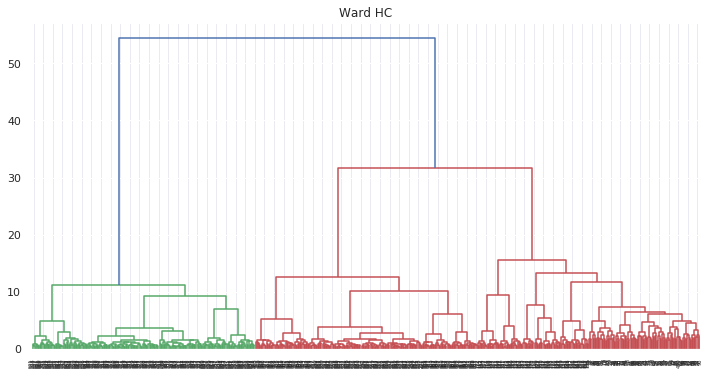

In [14]:
Z = hierarchy.linkage(pdist(data), 'ward')
plt.figure(figsize=(12, 6))
dn = hierarchy.dendrogram(Z)
plt.title('Ward HC');

## Deacreasing / Downshift subproblem

We now take a closer look at differentiating between the *decreasing* and *downshift* time-series, one of the problematic couples. We focus on the soft_dtw distance since it is the one that seems to yield the best results.

### Heatmap

100%|██████████| 200/200 [00:01<00:00, 124.67it/s]


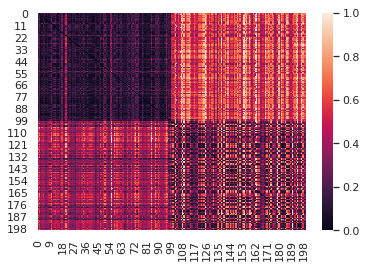

In [15]:
data = np.load('data/synthetic_control')
data = np.array([moving_average(a, n=5) for a in data])
data = TimeSeriesScalerMinMax().fit_transform(data).reshape(data.shape)

# Recreate the distance matrix for simplicity.
# data = np.concatenate([data[300:400], data[500:600]])
data = np.concatenate([data[200:300], data[400:500]])
up_inc_distances = distance_matrix(data, soft_dtw_parser)
up_inc_distances = MinMaxScaler().fit_transform(up_inc_distances).T
sns.heatmap(up_inc_distances);

### Clustering and Accuracy

In [16]:
true_clusters = np.concatenate(([1]*100 ,[0]*100))
clusters = AgglomerativeClustering(n_clusters=2,affinity='precomputed',
                                   linkage="complete").fit_predict(up_inc_distances)
print('Accuracy score: {}'.format(accuracy_score(true_clusters, clusters)))

Accuracy score: 0.89


Note that the same analysis ran on *increasing*/*upshift* yields a relatively different accuracy. This is most likely due to the randomness in the data, as there are no intrinsic reason why it would be the case.

### PCA Visualization

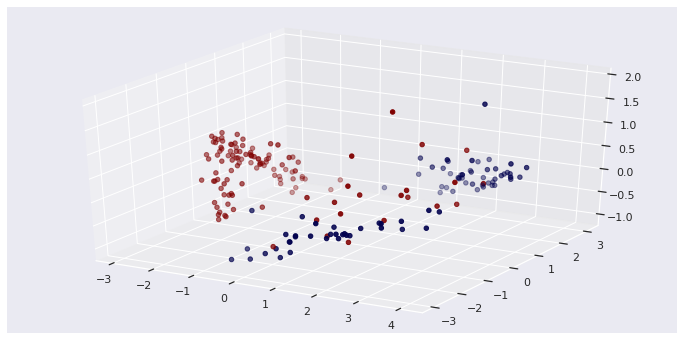

In [17]:
pca_x, pca_y, pca_z = PCA(n_components=3).fit_transform(up_inc_distances).T
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_x, pca_y, pca_z, c=clusters, cmap='seismic');

# Next steps

More features-engineering would be a natural next step.

Coming soon. Probably.